<a href="https://colab.research.google.com/github/Ankit-Patra/Energy-Efficient-Green-Database-Systems-Adaptive-Resource-Allocation-in-Cloud-Platforms/blob/main/MinorProjectFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Mount Google Drive
# In this cell, we mount the Google Drive to access the dataset stored in it.

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
# Cell 2: Import Libraries
# We import the necessary libraries for data manipulation, model building, and visualization.

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt



In [3]:
# Cell 3: Load the CSV File
# We load the CSV file containing AWS system usage data from Google Drive.

csv_file_path = '/content/drive/MyDrive/Minor_Project/aws_system_usage_data.csv'  # Adjust this path
df = pd.read_csv(csv_file_path, parse_dates=['timestamp'])

# Display the first few rows of the dataset to confirm successful loading
df.head()



,timestamp,instance_id,region,instance_type,cpu_usage,memory_usage,storage_usage,cpu_credits,network_in,network_out,query_response_time,cpu_allocation,memory_allocation,storage_allocation,active_connections,query_complexity
0,2023-01-01 00:00:00,i-0abcd1234efgh5678,us-west-2,t2.micro,51.891274,3.719284,91.807802,6,304,171,155.012301,4,8,100,5,3
1,2023-01-01 00:05:00,i-2abcd1234efgh5680,us-west-2,r5.xlarge,51.620089,4.124900,88.491697,17,902,577,169.330019,4,8,100,16,2
2,2023-01-01 00:10:00,i-0abcd1234efgh5678,eu-west-1,t2.micro,44.290703,4.393093,88.601060,29,813,542,153.545545,4,8,100,16,2
3,2023-01-01 00:15:00,i-0abcd1234efgh5678,us-east-1,r5.xlarge,48.757237,4.068880,87.154717,74,183,84,174.242140,4,8,100,23,2
4,2023-01-01 00:20:00,i-0abcd1234efgh5678,eu-west-1,t2.micro,44.861956,3.263330,90.351162,95,900,903,113.261686,4,8,100,27,3


In [4]:
# Cell 4: Data Preprocessing
# We preprocess the data by extracting features such as CPU, memory, and storage usage, and normalizing them.

def preprocess_data(df):
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek

    features = ['cpu_usage', 'memory_usage', 'storage_usage', 'active_connections',
                'query_complexity', 'hour', 'day_of_week']
    targets = ['cpu_usage', 'memory_usage', 'storage_usage']

    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    return df, features, targets, scaler

df, features, targets, scaler = preprocess_data(df)



In [5]:
# Cell 5: Prepare Data for LSTM
# We prepare the data for the LSTM model by using past 12 time steps to predict the next step.

X, y = [], []
for i in range(12, len(df)):
    X.append(df[features].values[i-12:i])
    y.append(df[targets].values[i])
X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [6]:
# Cell 6: Create and Train LSTM Model
# We define the LSTM model and train it on the training dataset.

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(3)  # Predict CPU, memory, and storage usage
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_model(X_train, y_train):
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    return model

model = train_model(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Cell 7: Prediction and Adjustment with 10% Change
# In this cell, we predict and adjust resource allocations based on the model predictions with a 10% threshold.

def predict_and_adjust(model, scaler, current_data, current_allocation):
    prediction = model.predict(current_data.reshape(1, current_data.shape[0], current_data.shape[1]))
    dummy_array = np.zeros((1, 7))
    dummy_array[:, :3] = prediction
    prediction = scaler.inverse_transform(dummy_array)[:, :3]
    prediction = prediction[0]

    adjustments = []
    for i, resource in enumerate(['CPU', 'Memory', 'Storage']):
        current = current_allocation[i]
        predicted = prediction[i]
        if predicted > current * 1.1:
            new_allocation = min(current * 1.1, current + 1)
            adjustments.append(f"Increase {resource} from {current:.2f} to {new_allocation:.2f}")
        elif predicted < current * 0.9:
            new_allocation = max(current * 0.9, current - 1)
            adjustments.append(f"Decrease {resource} from {current:.2f} to {new_allocation:.2f}")
        else:
            adjustments.append(f"Maintain {resource} at {current:.2f}")

    return adjustments

# Example simulation
current_allocation = [4, 8, 100]  # Initial allocation for CPU, memory, storage
adjustments = predict_and_adjust(model, scaler, X_test[0], current_allocation)
print(f"Adjustments: {adjustments}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Adjustments: ['Increase CPU from 4.00 to 4.40', 'Decrease Memory from 8.00 to 7.20', 'Maintain Storage at 100.00']


In [8]:
# Cell 8: Prediction and Adjustment with 40% Change
# In this cell, we predict and adjust resource allocations based on the model predictions with a 40% threshold.

def predict_and_adjust_40(model, scaler, current_data, current_allocation):
    prediction = model.predict(current_data.reshape(1, current_data.shape[0], current_data.shape[1]))
    dummy_array = np.zeros((1, 7))
    dummy_array[:, :3] = prediction
    prediction = scaler.inverse_transform(dummy_array)[:, :3]
    prediction = prediction[0]

    adjustments = []
    for i, resource in enumerate(['CPU', 'Memory', 'Storage']):
        current = current_allocation[i]
        predicted = prediction[i]
        if predicted > current * 1.4:
            new_allocation = min(current * 1.4, current + 1)
            adjustments.append(f"Increase {resource} from {current:.2f} to {new_allocation:.2f}")
        elif predicted < current * 0.6:
            new_allocation = max(current * 0.6, current - 1)
            adjustments.append(f"Decrease {resource} from {current:.2f} to {new_allocation:.2f}")
        else:
            adjustments.append(f"Maintain {resource} at {current:.2f}")

    return adjustments

# Example simulation
adjustments_40 = predict_and_adjust_40(model, scaler, X_test[0], current_allocation)
print(f"Adjustments (40%): {adjustments_40}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Adjustments (40%): ['Increase CPU from 4.00 to 5.00', 'Decrease Memory from 8.00 to 7.00', 'Maintain Storage at 100.00']


In [9]:
# Cell 9: Evaluate the Model
# We evaluate the LSTM model using Mean Squared Error on the test dataset.

mse = model.evaluate(X_test, y_test)
print(f"Model Mean Squared Error: {mse}")



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1036
Model Mean Squared Error: 0.10394655913114548


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


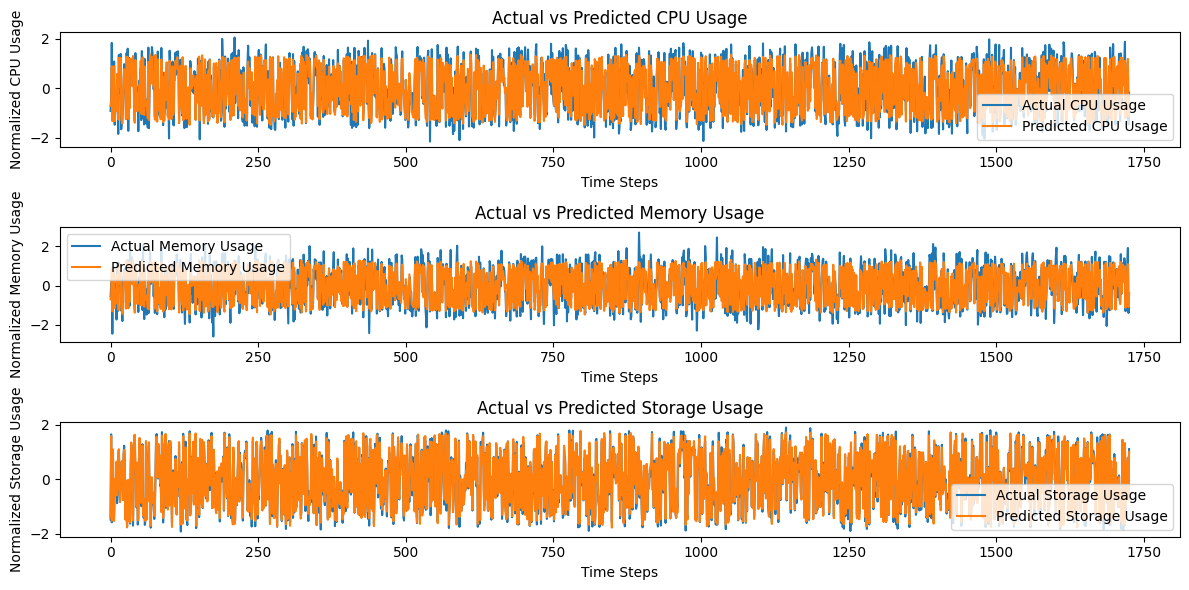

In [10]:
# Cell 10: Plot Actual vs Predicted Resource Utilization
# We plot graphs to visualize the actual vs predicted usage of CPU, memory, and storage.

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(y_test[:, 0], label='Actual CPU Usage')
plt.plot(y_pred[:, 0], label='Predicted CPU Usage')
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Time Steps')
plt.ylabel('Normalized CPU Usage')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(y_test[:, 1], label='Actual Memory Usage')
plt.plot(y_pred[:, 1], label='Predicted Memory Usage')
plt.title('Actual vs Predicted Memory Usage')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Memory Usage')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(y_test[:, 2], label='Actual Storage Usage')
plt.plot(y_pred[:, 2], label='Predicted Storage Usage')
plt.title('Actual vs Predicted Storage Usage')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Storage Usage')
plt.legend()

plt.tight_layout()
plt.show()



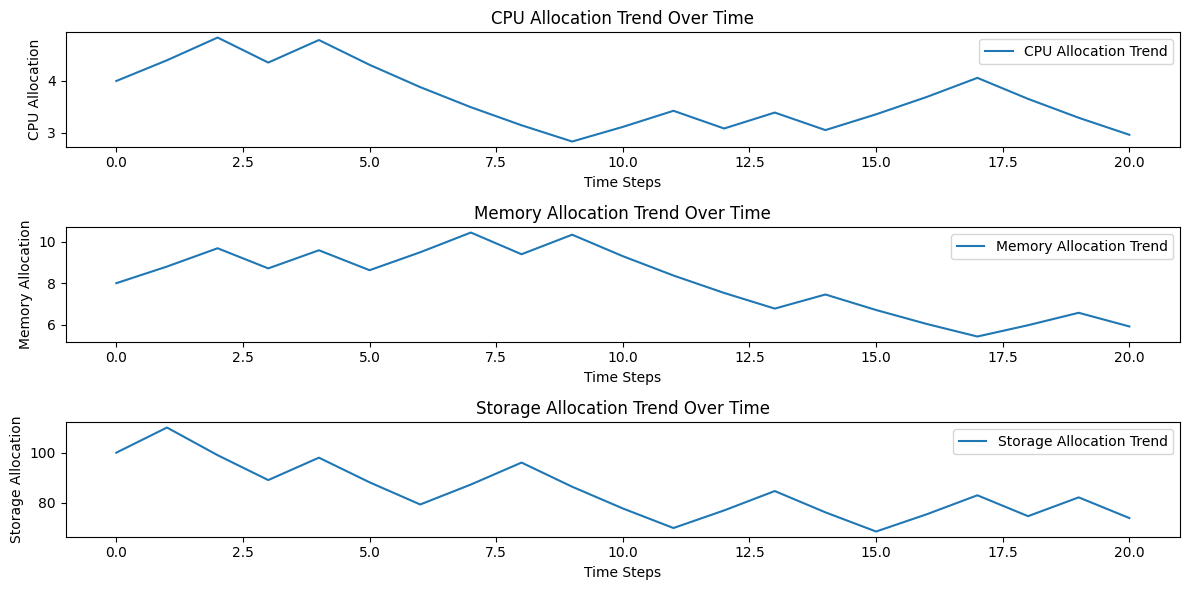

In [11]:
# Cell 11: Time Series Trend of Resource Allocation
# We visualize the time series trend of resource allocations.

current_allocation_trend = [4, 8, 100]
adjustment_factors = [1.1, 0.9]  # Example adjustment factors for increasing/decreasing resources

cpu_trend = [current_allocation_trend[0]]
memory_trend = [current_allocation_trend[1]]
storage_trend = [current_allocation_trend[2]]

for i in range(20):  # Simulate 20 time steps
    new_cpu = cpu_trend[-1] * np.random.choice(adjustment_factors)
    new_memory = memory_trend[-1] * np.random.choice(adjustment_factors)
    new_storage = storage_trend[-1] * np.random.choice(adjustment_factors)
    cpu_trend.append(new_cpu)
    memory_trend.append(new_memory)
    storage_trend.append(new_storage)

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(cpu_trend, label='CPU Allocation Trend')
plt.title('CPU Allocation Trend Over Time')
plt.xlabel('Time Steps')
plt.ylabel('CPU Allocation')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(memory_trend, label='Memory Allocation Trend')
plt.title('Memory Allocation Trend Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Memory Allocation')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(storage_trend, label='Storage Allocation Trend')
plt.title('Storage Allocation Trend Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Storage Allocation')
plt.legend()

plt.tight_layout()
plt.show()


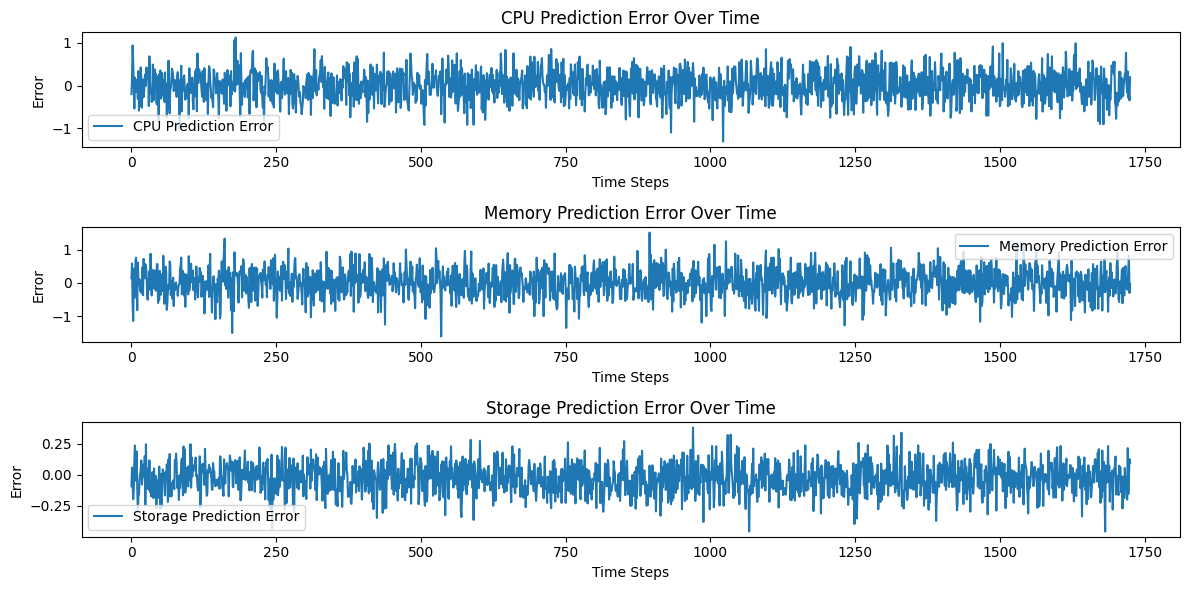

In [12]:
# Cell 13: Line Plot of Prediction Error over Time
# We plot the difference (error) between actual and predicted resource usage over time.

cpu_error = y_test[:, 0] - y_pred[:, 0]
memory_error = y_test[:, 1] - y_pred[:, 1]
storage_error = y_test[:, 2] - y_pred[:, 2]

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(cpu_error, label='CPU Prediction Error')
plt.title('CPU Prediction Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(memory_error, label='Memory Prediction Error')
plt.title('Memory Prediction Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(storage_error, label='Storage Prediction Error')
plt.title('Storage Prediction Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()


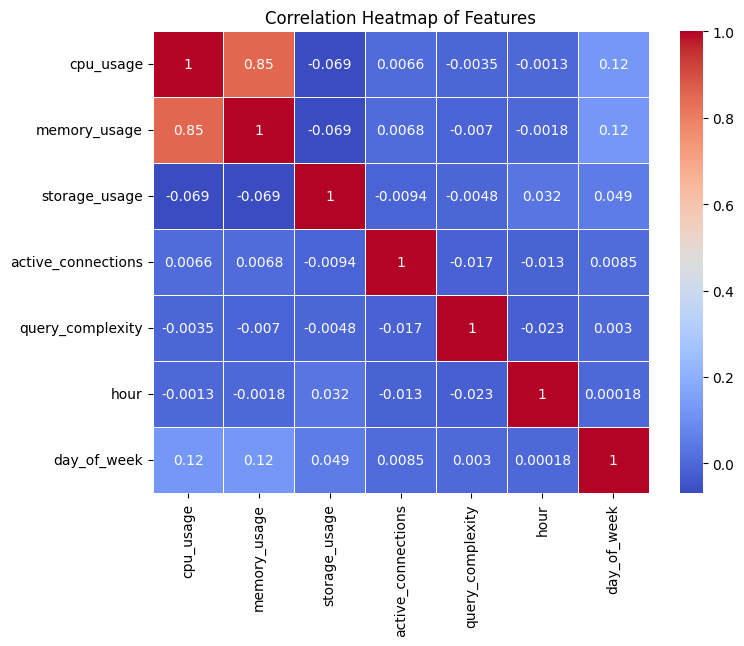

In [13]:
# Cell 14: Correlation Heatmap of Features
# We plot a heatmap to show the correlation between different features used in the model.

import seaborn as sns

# Calculate correlation matrix
corr_matrix = df[features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()


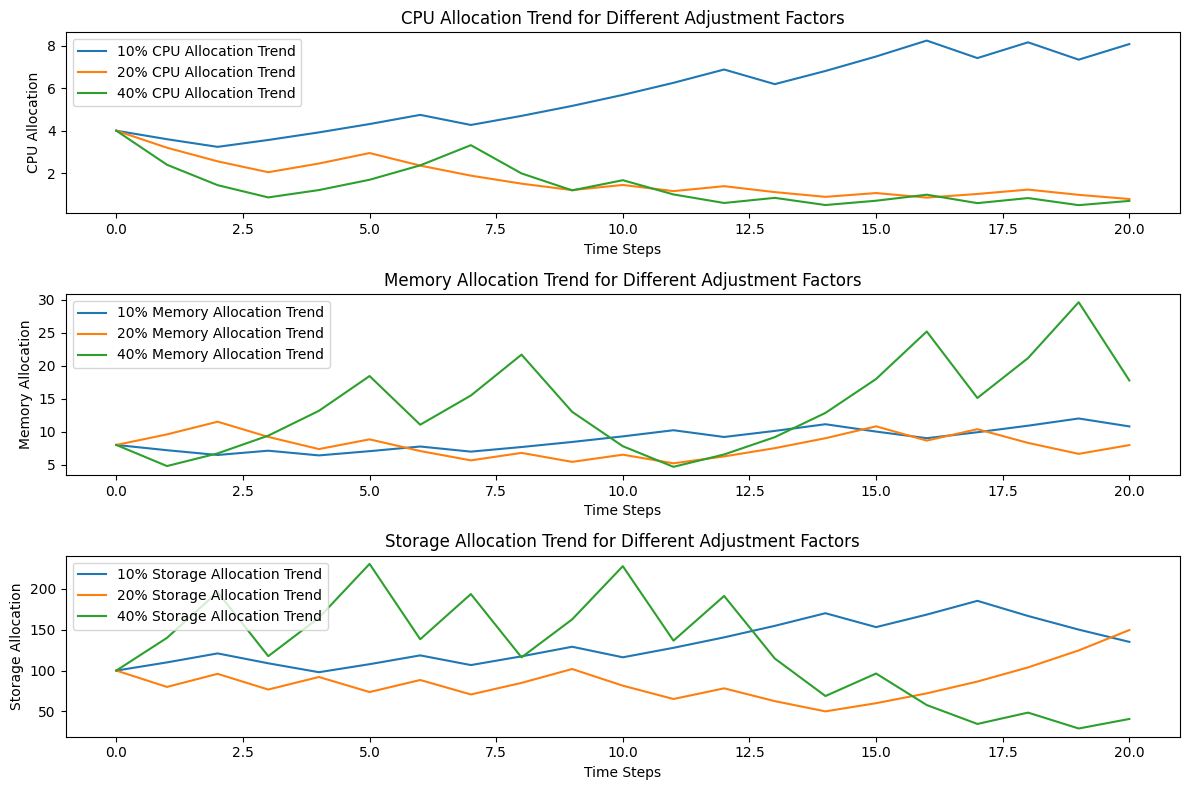

In [14]:
# Cell 15: CPU, Memory, and Storage Allocation Line Plot with Different Adjustment Factors
# We visualize the changes in CPU, memory, and storage allocations under different adjustment factors (e.g., 10%, 20%, 40%).

adjustment_factors_10 = [1.1, 0.9]
adjustment_factors_20 = [1.2, 0.8]
adjustment_factors_40 = [1.4, 0.6]

cpu_trend_10 = [current_allocation_trend[0]]
memory_trend_10 = [current_allocation_trend[1]]
storage_trend_10 = [current_allocation_trend[2]]

cpu_trend_20 = [current_allocation_trend[0]]
memory_trend_20 = [current_allocation_trend[1]]
storage_trend_20 = [current_allocation_trend[2]]

cpu_trend_40 = [current_allocation_trend[0]]
memory_trend_40 = [current_allocation_trend[1]]
storage_trend_40 = [current_allocation_trend[2]]

for i in range(20):  # Simulate 20 time steps for each adjustment factor
    # For 10%
    cpu_trend_10.append(cpu_trend_10[-1] * np.random.choice(adjustment_factors_10))
    memory_trend_10.append(memory_trend_10[-1] * np.random.choice(adjustment_factors_10))
    storage_trend_10.append(storage_trend_10[-1] * np.random.choice(adjustment_factors_10))

    # For 20%
    cpu_trend_20.append(cpu_trend_20[-1] * np.random.choice(adjustment_factors_20))
    memory_trend_20.append(memory_trend_20[-1] * np.random.choice(adjustment_factors_20))
    storage_trend_20.append(storage_trend_20[-1] * np.random.choice(adjustment_factors_20))

    # For 40%
    cpu_trend_40.append(cpu_trend_40[-1] * np.random.choice(adjustment_factors_40))
    memory_trend_40.append(memory_trend_40[-1] * np.random.choice(adjustment_factors_40))
    storage_trend_40.append(storage_trend_40[-1] * np.random.choice(adjustment_factors_40))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(cpu_trend_10, label='10% CPU Allocation Trend')
plt.plot(cpu_trend_20, label='20% CPU Allocation Trend')
plt.plot(cpu_trend_40, label='40% CPU Allocation Trend')
plt.title('CPU Allocation Trend for Different Adjustment Factors')
plt.xlabel('Time Steps')
plt.ylabel('CPU Allocation')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(memory_trend_10, label='10% Memory Allocation Trend')
plt.plot(memory_trend_20, label='20% Memory Allocation Trend')
plt.plot(memory_trend_40, label='40% Memory Allocation Trend')
plt.title('Memory Allocation Trend for Different Adjustment Factors')
plt.xlabel('Time Steps')
plt.ylabel('Memory Allocation')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(storage_trend_10, label='10% Storage Allocation Trend')
plt.plot(storage_trend_20, label='20% Storage Allocation Trend')
plt.plot(storage_trend_40, label='40% Storage Allocation Trend')
plt.title('Storage Allocation Trend for Different Adjustment Factors')
plt.xlabel('Time Steps')
plt.ylabel('Storage Allocation')
plt.legend()

plt.tight_layout()
plt.show()

